# e4e setup, run once only!

In [7]:
#@title Setup (may take a few minutes)
import os
import time
import datetime
tic = time.time()
os.chdir('/content')
CODE_DIR = 'encoder4editing'

#%tensorflow_version 1.x
#! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 
!pip -q install ipympl nodejs
#!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
#!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
#!sudo unzip ninja-linux.zip -d /usr/local/bin/
#!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')
print(str(datetime.datetime.now()) + " - Importing Modules.")
from argparse import Namespace
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import ipywidgets
print(str(datetime.datetime.now()) + " - Done.")
sys.path.append(".")
sys.path.append("..")
print(str(datetime.datetime.now()) + " - Importing Model.")
from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.
print(str(datetime.datetime.now()) + " - Done.")
%load_ext autoreload
%autoreload 2

#Merged Experiment Var Setup
print(str(datetime.datetime.now()) + " - Setting Experiment Vars.")
experiment_type = 'ffhq_encode'
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 
#Do Not Run or This will Overwrite the Good One.
#!wget {download_command}
print(str(datetime.datetime.now()) + " - Done.")

#Merged Model Loading
os.chdir('/content/encoder4editing')
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_name": "",
    }
    
}
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
tic = time.time()
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print(str(datetime.datetime.now()) + ' - Model successfully loaded!')
toc = time.time()
print(str(datetime.datetime.now()) + ' - Loading took {:.4f} seconds.'.format(toc - tic))
print(str(datetime.datetime.now()) + " - e4e Initial Setup Complete.")
toc = time.time()
print(str(datetime.datetime.now()) + ' - Loading took {:.4f} seconds.'.format(toc - tic))

You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
2021-10-15 10:58:44.690610 - Importing Modules.
2021-10-15 10:58:44.691671Done.
2021-10-15 10:58:44.692073 - Importing Model.
Done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2021-10-15 10:58:44.694179 - Setting Experiment Vars.
2021-10-15 10:58:44.695565 - Done.
Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
2021-10-15 10:58:48.547261 - Model successfully loaded!
2021-10-15 10:58:48.547486 - Loading took 3.8516 seconds.
2021-10-15 10:58:48.547600 - e4e Initial Setup Complete.
2021-10-15 10:58:48.547754 - Loading took 3.8519 seconds.


# StyleCLIP setup, run once only!

In [5]:
%cd
%cd /content/
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tac = time.time()
#! pip install ftfy regex tqdm 
#!pip install git+https://github.com/openai/CLIP.git 
#! git clone https://github.com/bycloudai/StyleCLIP

dataset_name='ffhq'
# input dataset name 

%cd
%cd /content/StyleCLIP/global/
# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

os.chdir('/content/StyleCLIP/global/')
print("Loading Modules.")
tic = time.time()
import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 
toc = time.time()
print(str(datetime.datetime.now()) + ' - Loading took {:.4f} seconds.'.format(toc - tic))
print("Loading Manipulator.")
M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)
print("StyleCLIP Setup Complete.")
tec = time.time()
print(str(datetime.datetime.now()) + ' - Total Setup Time {:.4f} seconds.'.format(tac - tec))

/root
/content
/root
/content/StyleCLIP/global
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.
get all z and w
Generate S
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1         

# e4e Inference Engine

In [207]:
#@markdown Upload an image to the encoder4editing folder and set the image_name into the image name
image_input = input("Image Location: ")
image_name = image_input
image_name = '/content/encoder4editing/images_in/' + image_name
print("Image Location set to:" + image_name)

# Setup required image transformations
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

Image Location:  rapunzel.JPG


Image Location set to:/content/encoder4editing/images_in/rapunzel.JPG


In [208]:
#@title
tic = time.time()
#image_path = EXPERIMENT_DATA_ARGS[experiment_type][image_name]
image_path = image_name
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print(str(datetime.datetime.now()) + " - Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image
toc = time.time()
print(str(datetime.datetime.now()) + ' - Alignment took {:.4f} seconds.'.format(toc - tic))
input_image.resize(resize_dims)

UnboundLocalError: local variable 'shape' referenced before assignment

2021-10-18 18:39:02.105457 - Inference took 0.1442 seconds.


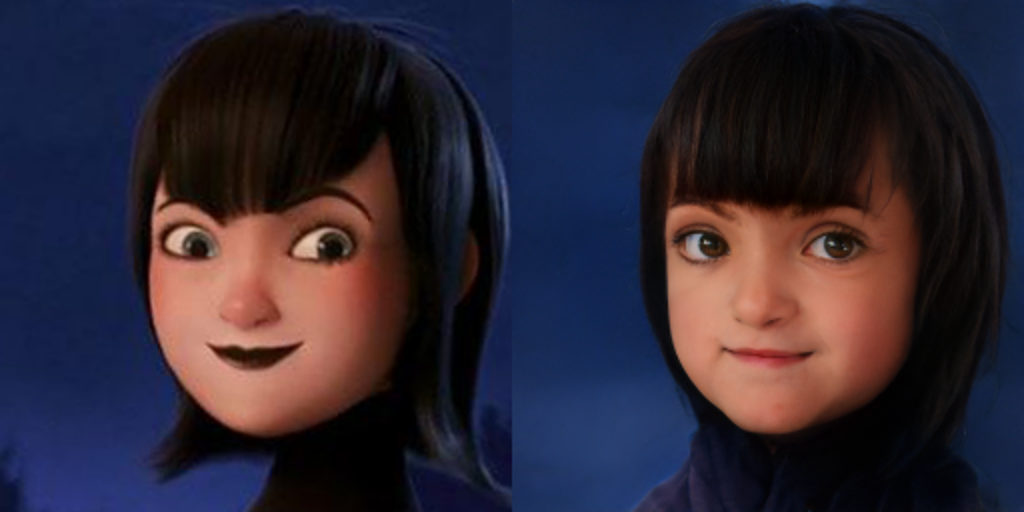

In [182]:
#@title
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print(str(datetime.datetime.now()) + ' - Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image).resize((1024,512))

In [32]:
#Save The Output Image, Optional
result_out = tensor2im(result_image).save('/content/encoder4editing/images_out/'+ image_input)

In [106]:
#Save The SideBySide Image, Optional
result_out = display_alongside_source_image(tensor2im(result_image), input_image).resize((1024,512)).save('/content/encoder4editing/images_out/both_'+ image_input)

In [183]:
#Send The Latents to the Next Layer
torch.save(latents, 'latents.pt')

# StyleCLIP Body

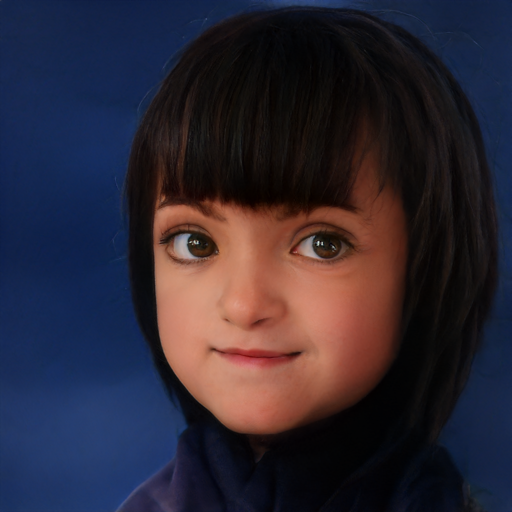

In [184]:
latents=torch.load('/content/encoder4editing/latents.pt') # located in the top-level folder in the Colab UI
w_plus=latents.cpu().detach().numpy()
dlatents_loaded=M.W2S(w_plus)

img_index = 0
img_indexs=[img_index]

dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0, dlatent_tmp) 
size= 1*512
original=Image.fromarray(out[0,0]).resize((size,size))
M.manipulate_layers=None
original

In [160]:
#Save The Hi-Res Output Image, Optional
result_out = original.save('/content/encoder4editing/images_out/styleclip_hi_'+ image_input)

# input text description 
"Neutral" should describe the original image
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |

# modify manipulation strength (alpha) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

In [205]:
neutral='child' #@param {type:"string"}
target='old woman' #@param {type:"string"}
beta = 0.08 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 2#@param {type:"slider", min:-10, max:10, step:0.1}

0.4177
num of channels being manipulated: 847


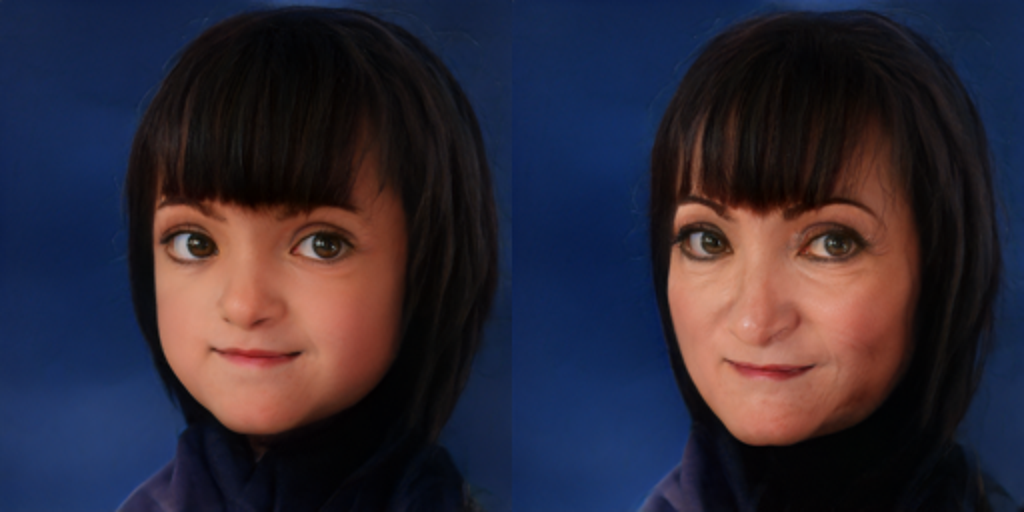

In [206]:

classnames=[target,neutral]
dt=GetDt(classnames,model)
#beta=0.1
#alpha=1

M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)

generated=Image.fromarray(out[0,0]).resize((512,512))

plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

display_alongside_source_image(generated, original).resize((1024,512))

In [155]:
#Save The Manipulated Image, Optional
result_out = generated.save('/content/encoder4editing/images_out/styleclip_mod_'+ image_input)

In [33]:
#Save The SideBySide Image, Optional
result_out = display_alongside_source_image(generated, original).resize((1024,512)).save('/content/encoder4editing/images_out/styleclip_mod_sxs_'+ image_input)